In [358]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from Constants import Const
import json
import Utils
import re
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.stats import chi2
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

from ast import literal_eval
import statsmodels.api as sm
import Metrics
import simplejson

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)

In [2]:
def nested_responsify(dictionary):
    if isinstance(dictionary,list) or isinstance(dictionary,set):
        vals = [nested_responsify(x) for i,x in enumerate(dictionary)]
        return vals
    new_dict= {}
    for k,v in dictionary.items():
        if isinstance(v,dict):

            new_dict[k] = nested_responsify(v)
        else:
            new_dict[k] = v
    djson = simplejson.dumps(new_dict,default=np_converter,ignore_nan=True)
    return djson.replace('\\"','\"')

In [39]:
def add_sd_dose_clusters(sddf, 
                         clusterer = None,
                         features=None,
                         reducer=None,
                         organ_subset=None,
                         normalize = True,
                         prefix='',
                         n_clusters = 4,
                        ):
    if clusterer is None:
        clusterer = BayesianGaussianMixture(n_init=5,
                                            n_components=n_clusters, 
                                            covariance_type="full",
                                            random_state=100)
    if features is None:
        features=['V35','V40','V45','V50','V55','V60','V65']
    if reducer is None:
        reducer= None#PCA(len(organ_list),whiten=True)
    if organ_subset is None:
        organ_subset = Const.organ_list[:]
    organ_positions = [Const.organ_list.index(o) for o in organ_subset]
    vals = np.stack(sddf[features].apply(lambda x: np.stack([np.array([ii[i] for i in organ_positions]).astype(float) for ii in x]).ravel(),axis=1).values)
    if normalize:
        vals = (vals - vals.mean(axis=0))/(vals.std(axis=0) + .01)
    if reducer is not None:
        vals = reducer.fit_transform(vals)
    df = pd.DataFrame(vals,index = sddf.index)
    clusters = clusterer.fit_predict(vals)
    new_df = sddf.copy()
    cname= prefix+'dose_clusters'
    new_df[cname] = clusters
    new_df = reorder_clusters(new_df,
                              cname,
                              by='mean_dose',
                              organ_list=organ_subset#order by mean dose to clustered organs
                             )
    return new_df

def reorder_clusters(df,cname,by='moderate_6wk_symptoms',organ_list=None):
    df = df.copy()
    df2 = df.copy()
    severities = {}
    clusts = sorted(df[cname].unique())
    getmean = lambda d: d[by].astype(float).mean()
    if organ_list is not None and Utils.iterable(df[by].iloc[0]):
        keep_idx = [Const.organ_list.index(o) for o in organ_list]
        df[by] = df[by].apply(lambda x: [x[i] for i in keep_idx])
    if Utils.iterable(df[by].iloc[0]):
        getmean = lambda d: np.stack(d[by].apply(lambda x: np.array(x).sum()).values).mean()
    for c in clusts:
        subset = df[df[cname] == c]
        avg_severity = getmean(subset)
        severities[c] = avg_severity
    clust_order = np.argsort(sorted(severities.keys(), key = lambda x: severities[x]))
    clust_map = {c: clust_order[i] for i,c in enumerate(clusts)}
    df2[cname] = df[cname].apply(lambda x: clust_map.get(x))
    return df2

def get_df_dose_cols(df,key='DV'):
    return [c for c in df.columns if re.match('[' + key + ']\d+',c) is not None]

def get_df_symptom_cols(df):
    return [c for c in df.columns if 'symptoms_' in c if 'original' not in c]
    
def add_symptom_groups(df):
    smap = {
        'salivary': ['drymouth','taste'],
        'throat':['swallow','choke','teeth','sob','mucositis'],
        'mouth':['drymouth','teeth','swallow'],
        'core': ['pain','fatigue','nausea','sleep',
                 "distress", "sob", "memory", "appetite", 
                "drowsy", "drymouth", "sad", "vomit", "numb"],
        'interference': ["activity", "mood", "work", 
                "relations", "walking","enjoy"],
        'hnc': ["mucus", "swallow", "choke", "voice", "skin", 
                "constipation", "taste", "mucositis", "teeth"],
    }
    df = df.copy()
    for name, symptoms in smap.items():
        array = []
        for s in symptoms:
            svals = np.stack(df['symptoms_'+s].apply(lambda x: np.array(x)).values)
            array.append(svals)
        array = np.stack(array,axis=-1)
        #rounding in the same weird way you do in microprocessor code
        smean = (100*array.mean(axis=-1)).astype('int')/100.0
        smax = array.max(axis=-1)
        df['symptoms_'+name+'_max'] = smax.tolist()
        df['symptoms_'+name+'_mean'] = smean.tolist()
    return df
    
def load_dose_symptom_data():
    data = pd.read_csv(Const.data_dir + 'dose_symptoms_merged.csv')
    to_drop = [c for c in data.columns if 'symptom' in c and ('symptoms_' not in c or 'original' in c)]
    data = data.drop(to_drop,axis=1)
    dose_cols = get_df_dose_cols(data)
    s_cols = get_df_symptom_cols(data) 
    for c in dose_cols + s_cols + ['max_dose','mean_dose','volume','dates']:
        try:
            data[c] = data[c].apply(literal_eval)
        except Exception as e:
            print(c,e)
    data = add_symptom_groups(data)
    return data
    
data = load_dose_symptom_data()
data.T
# add_sd_dose_clusters(data)

,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
id,7,8,9,10,11,13,15,16,18,22,...,792,794,797,800,803,807,809,811,813,816
D10,"[37.625, 37.15625, 66.3125, 60.3125, 49.4375, ...","[32.15625, 32.0625, 65.375, 56.6875, 22.5, 31....","[51.4375, 27.515625, 51.4375, 51.4375, 18.6875...","[44.21875, 35.625, 55.9375, 64.75, 52.84375, 5...","[26.15625, 31.984375, 57.125, 45.40625, 29.265...","[42.21875, 29.625, 48.6875, 60.46875, 19.5, 41...","[44.90625, 33.28125, 57.71875, 47.75, 43.625, ...","[24.9375, 32.28125, 56.84375, 52.625, 39.09375...","[51.4375, 29.78125, 51.4375, 51.4375, 30.5625,...","[45.4375, 35.125, 64.8125, 71.375, 62.78125, 6...",...,"[15.09375, 16.125, 44.5625, 15.6015625, 20.578...","[30.34375, 26.515625, 52.15625, 47.53125, 40.8...","[28.28125, 30.0625, 56.84375, 58.3125, 55.6875...","[13.7421875, 18.546875, 34.875, 28.5625, 21.56...","[51.4375, 10.3125, 14.53125, 2.6796875, 1.8603...","[35.0625, 38.71875, 55.03125, 57.15625, 38.5, ...","[1.580078125, 6.76171875, 17.4375, 2.419921875...","[51.4375, 24.453125, 51.4375, 51.4375, 26.0312...","[51.4375, 0.0200042724609375, 51.4375, 51.4375...","[7.55859375, 10.3125, 17.15625, 24.59375, 20.6..."
D15,"[36.5625, 36.75, 64.0625, 59.96875, 48.375, 49...","[31.703125, 31.109375, 63.34375, 55.75, 21.312...","[48.59375, 26.671875, 48.59375, 48.59375, 15.0...","[43.1875, 34.28125, 54.3125, 62.6875, 50.78125...","[25.625, 31.359375, 56.875, 45.15625, 26.48437...","[41.8125, 29.046875, 48.15625, 58.34375, 14.52...","[44.0, 32.75, 57.21875, 47.5625, 40.40625, 48....","[24.0, 31.453125, 56.125, 51.9375, 34.15625, 4...","[48.59375, 28.984375, 48.59375, 48.59375, 29.2...","[44.34375, 34.03125, 63.78125, 70.8125, 59.312...",...,"[13.5625, 15.4765625, 43.25, 14.390625, 20.234...","[29.703125, 26.078125, 49.625, 45.4375, 39.937...","[26.75, 29.4375, 53.96875, 54.875, 54.34375, 4...","[13.1875, 17.765625, 34.34375, 27.0625, 21.218...","[48.59375, 10.046875, 14.1875, 1.9296875, 1.75...","[34.53125, 38.28125, 54.46875, 55.5, 37.0625, ...","[1.1796875, 6.51171875, 16.65625, 2.23046875, ...","[48.59375, 23.265625, 48.59375, 48.59375, 23.6...","[48.59375, 0.0200042724609375, 48.59375, 48.59...","[5.51171875, 9.8203125, 13.7578125, 22.015625,..."
D2,"[39.96875, 38.0625, 71.8125, 60.90625, 52.1562...","[33.4375, 34.09375, 68.75, 58.28125, 33.6875, ...","[56.65625, 29.5625, 56.65625, 56.65625, 27.312...","[47.84375, 39.21875, 58.15625, 68.5625, 57.406...","[27.5625, 33.25, 57.65625, 45.84375, 36.75, 44...","[43.0, 31.0, 54.09375, 70.625, 35.5625, 51.0, ...","[46.5, 34.9375, 58.71875, 48.375, 46.875, 51.9...","[28.5, 34.84375, 58.4375, 53.65625, 48.3125, 5...","[56.65625, 31.953125, 56.65625, 56.65625, 34.5...","[48.875, 38.09375, 69.25, 72.25, 67.625, 66.62...",...,"[17.375, 19.390625, 46.1875, 16.84375, 21.2187...","[32.09375, 27.90625, 55.53125, 52.53125, 43.96...","[34.3125, 31.390625, 64.0625, 64.25, 59.09375,...","[14.4921875, 20.734375, 36.125, 30.59375, 23.5...","[56.65625, 11.0078125, 16.4375, 4.33984375, 2....","[38.125, 39.65625, 56.21875, 58.28125, 43.4062...","[2.6796875, 7.2890625, 18.40625, 3.48046875, 5...","[56.65625, 27.078125, 56.65625, 56.65625, 33.5...","[56.65625, 0.0200042724609375, 56.65625, 56.65...","[12.3203125, 11.328125, 28.546875, 33.75, 25.0..."
D20,"[35.25, 36.34375, 62.71875, 59.71875, 47.34375...","[31.203125, 30.25, 61.34375, 54.5625, 17.84375...","[46.03125, 25.9375, 46.03125, 46.03125, 13.0, ...","[42.0, 33.125, 52.84375, 59.53125, 48.875, 46....","[25.09375, 30.71875, 56.65625, 45.0, 22.828125...","[41.40625, 28.46875, 47.8125, 56.4375, 12.9921...","[43.0625, 32.28125, 56.625, 47.375, 37.15625, ...","[22.6875, 30.375, 55.5, 51.375, 30.84375, 43.6...","[46.03125, 28.3125, 46.03125, 46.03125, 28.265...","[43.5, 33.25, 62.8125, 68.6875, 56.28125, 60.9...",...,"[12.5703125, 15.0, 41.96875, 12.2734375, 19.95...","[29.015625, 25.71875, 48.03125, 44.09375, 39.1...","[25.609375, 28.78125, 51.9375, 52.40625, 53.21...","[12.4921875, 17.0625, 34.0, 25.65

In [62]:
#overly complicated code to get various p-values using likelihood ratio test
#good for just correlations vs symptoms
def add_confounder_dose_limits(df,organ_list=None):
    #dose limits as binary values from https://applications.emro.who.int/imemrf/Rep_Radiother_Oncol/Rep_Radiother_Oncol_2013_1_1_35_48.pdf
    #not inlcudeing other stuff like eyes at this time
    #also, my max dose is weird so I'm using V10 for that because I feel like that makes sense
    #using the 
    if organ_list is None:
        organ_list = Const.organ_list[:]
    df = df.copy()
    original_cols = set(df.columns)
    getval = lambda organ,param: df[param].apply(lambda x: x[organ_list.index(organ)])
    get_lr_val = lambda organ,param: np.maximum(getval('Lt_'+organ,param),getval('Rt_'+organ,param))
    
    maxdose_var = 'max_dose'
   
    #xerostomia. >25 for 1 or >20 for both
    df['Parotid_Gland_limit'] = (get_lr_val('Parotid_Gland','mean_dose') > 20) | (getval('Lt_Parotid_Gland','mean_dose') > 25) | (getval('Rt_Parotid_Gland','mean_dose') > 25)
    
    #there is 50 for PEG tube and 60 for aspiration so i'll do 50
    for o in ['IPC','MPC',"SPC"]:
        df[o+"_limit"] = getval(o,'mean_dose') > 50
        df[o+"_limit2"] = getval(o,'mean_dose') > 60
    
    #edema
    df['Larynx_limit'] = getval('Larynx','V50') > 27
    
    #Esophagitus
    elimits = [('V35',50),('V50',40),('V70',20),('V60',30)]
    df['Esophagus_limit'] = np.stack([(getval('Esophagus',v) > lim) for v,lim in elimits]).sum(axis=0) > 0
    return df

def add_total_doses(df,cols):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            df['total_'+col] = df[col].apply(np.sum)
    return df


def var_test(df, testcol, ycol,xcols, 
             regularize = False,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if testcol not in xcols:
        xcols = xcols + [testcol]
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .001)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcol,axis=1)
    boolean = (y.max() <= 1) and (len(y.unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,1)
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    
    results = {
        'ttest_pval': logit_res.pvalues[testcol],
        'ttest_tval': logit_res.tvalues[testcol],
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff
    }
    return results

def get_cluster_lrt(df,clust_key = 'dose_clusters',
                             symptoms=None,
                             nWeeks = None,
                             thresholds=None,
                             confounders=None,
                            ):
    #add tests for pvalues for data
    # print('cluster lrt',symptoms)
    if symptoms is None:
        symptoms = Const.symptoms[:]
    if nWeeks is None:
        nWeeks = [13,33]
    if confounders is None:
        confounders = [
            't4',
            't3',
            'n_severe',
            'hpv',
#             'BOT',
#             'Tonsil',
#             'total_mean_dose',
           #'Larynx_limit',
           'Parotid_Gland_limit'
                      ]
    date_keys = [df.dates.iloc[0].index(week) for week in nWeeks if week in df.dates.iloc[0]]
    #calculate change from baseline instead of absolute
    get_symptom_max = lambda x: np.max([x[d] for d in date_keys])
    df = df.copy()
    df = add_confounder_dose_limits(df)
    
    tdose_cols = [c.replace('total_','') for c in confounders if 'total_' in c]
    if len(tdose_cols) > 0:
        df = add_total_doses(df,tdose_cols)
        
    for symptom in symptoms:
        skey = 'symptoms_'+symptom
        if skey not in df.columns:
            continue
        max_symptoms = df[skey].apply(get_symptom_max).values
        for threshold in [-1,3, 5, 7]:
            colname=  'cluster_'+symptom
            boolean = threshold > 0
            if boolean:
                y = max_symptoms >= threshold
                colname += '_'+str(threshold)
            else:
                y = max_symptoms#/10
            names = ['lrt_pval','ttest_tval','ttest_pval','aic_diff']
            for n in names:
                df[colname+'_'+n] = -1
            for clust in df[clust_key].unique():
                in_clust = df[clust_key] == clust
                if len(np.unique(y)) < 2:
                    continue
                else:
                    df['x'] = in_clust
                    df['y'] = y
                    res = var_test(df,'x','y',confounders)
                    for name in names:
                        if not pd.isnull(res[name]):
                            df.loc[df[in_clust].index,[colname+'_'+name]] = res[name]
                    
    return df
       
    
ooi = [
    'Tongue',
       'Genioglossus_M',
       'Mylogeniohyoid_M',
       'Extended_Oral_Cavity',
         'Rt_Parotid_Gland',
       'Lt_Parotid_Gland',
         'Rt_Submandibular_Gland',
       'Lt_Submandibular_Gland',
      ]
tempdf = add_sd_dose_clusters(data,
                              features=['V45','V50','V55','V60'],
                              organ_subset = ooi)
temp = get_cluster_lrt(tempdf,symptoms=['drymouth'],)
for c,subdf in temp.groupby('dose_clusters'):
    print(c,subdf[['cluster_drymouth_'+str(n)+'_ttest_pval' for n in [3,5,7]]].mean())

0 cluster_drymouth_3_ttest_pval    0.126052
cluster_drymouth_5_ttest_pval    0.920708
cluster_drymouth_7_ttest_pval    0.084593
dtype: float64
1 cluster_drymouth_3_ttest_pval    0.123799
cluster_drymouth_5_ttest_pval    0.004610
cluster_drymouth_7_ttest_pval    0.008412
dtype: float64
2 cluster_drymouth_3_ttest_pval    0.103166
cluster_drymouth_5_ttest_pval    0.759786
cluster_drymouth_7_ttest_pval    0.522383
dtype: float64
3 cluster_drymouth_3_ttest_pval    0.001715
cluster_drymouth_5_ttest_pval    0.003870
cluster_drymouth_7_ttest_pval    0.004433
dtype: float64


In [5]:
#old stuff 
def get_cluster_correlations(df,clust_key = 'dose_clusters',
                             symptoms=None,
                             nWeeks = None,
                             thresholds=None,
                             baselines=[False],
                            ):
    #add tests for pvalues for data
    if symptoms is None:
        symptoms = Const.symptoms[:]
    if nWeeks is None:
        nWeeks = [13,33]
    if thresholds is None:
        thresholds = [5,7]
    date_keys = [df.dates.iloc[0].index(week) for week in nWeeks if week in df.dates.iloc[0]]
    #calculate change from baseline instead of absolute
    get_symptom_change_max = lambda x: np.max([x[d]-x[0] for d in date_keys])
    get_symptom_max = lambda x: np.max([x[d] for d in date_keys])
    df = df.copy()
    clust_results = []
    
    for symptom in symptoms:
        skey = 'symptoms_'+symptom
        if skey not in df.columns:
            continue
        max_symptoms = df[skey].apply(get_symptom_max).values
        max_change = df[skey].apply(get_symptom_change_max).values
        for threshold in thresholds:
            for baseline in baselines:
                if baseline:
                    y = (max_change >= threshold).astype(int)
                else:
                    y = (max_symptoms >= threshold).astype(int)
                colname=  'cluster_'+symptom
                if baseline:
                    colname += '_change'
                colname += "_" + str(threshold)
                df[colname+'_odds_ratio'] = -1
                df[colname+'_pval'] = -1
                for clust in df[clust_key].unique():
                    in_clust = df[clust_key] == clust
                    if len(np.unique(y)) < 2:
                        (odds_ratio,pval) = (0,1)
                    else:
                        (odds_ratio, pval) = Metrics.boolean_fisher_exact(in_clust.astype(int),y)
                    df.loc[df[in_clust].index,[colname+'_odds_ratio']] = odds_ratio
                    df.loc[df[in_clust].index,[colname+'_pval']] = pval
    return df
        
        
tempdf = add_sd_dose_clusters(data,organ_subset = ['IPC','SPC',"MPC"])
temp = get_cluster_correlations(tempdf,thresholds=[5,7,9],baselines=[False])
temp[[c for c in temp.columns if '_odds_ratio' in c or '_pval' in c]]

,cluster_pain_5_odds_ratio,cluster_pain_5_pval,cluster_pain_7_odds_ratio,cluster_pain_7_pval,cluster_pain_9_odds_ratio,cluster_pain_9_pval,cluster_fatigue_5_odds_ratio,cluster_fatigue_5_pval,cluster_fatigue_7_odds_ratio,cluster_fatigue_7_pval,...,cluster_walking_7_odds_ratio,cluster_walking_7_pval,cluster_walking_9_odds_ratio,cluster_walking_9_pval,cluster_enjoy_5_odds_ratio,cluster_enjoy_5_pval,cluster_enjoy_7_odds_ratio,cluster_enjoy_7_pval,cluster_enjoy_9_odds_ratio,cluster_enjoy_9_pval
0,0.907580,0.863563,0.508136,0.408370,0.000000,1.000000,1.106647,0.773378,1.873357,0.107960,...,0.746795,1.000000,1.132075,1.000000,1.429213,0.311895,1.617739,0.339246,0.669231,0.761387
1,0.959707,1.000000,0.891304,1.000000,0.000000,1.000000,1.556158,0.245867,0.625287,0.595391,...,1.265217,0.673787,3.180851,0.359344,1.305000,0.502983,2.544643,0.099457,4.258721,0.021882
2,0.875897,0.857016,0.913858,1.000000,2.771739,0.462504,0.759386,0.452806,0.752093,0.675471,...,1.393258,0.739818,0.000000,0.567834,1.157111,0.725509,0.415789,0.213492,0.820000,1.000000
3,0.959707,1.000000,0.891304,1.000000,0.000000,1.000000,1.556158,0.245867,0.625287,0.595391,...,1.265217,0.673787,3.180851,0.359344,1.305000,0.502983,2.544643,0.099457,4.258721,0.021882
4,0.907580,0.863563,0.508136,0.408370,0.000000,1.000000,1.106647,0.773378,1.873357,0.107960,...,0.746795,1.000000,1.132075,1.000000,1.429213,0.311895,1.617739,0.339246,0.669231,0.761387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,1.267442,0.485186,1.977541,0.256257,2.470000,0.495636,0.873358,0.769509,0.802867,0.686669,...,0.812925,1.000000,1.230000,1.000000,0.447312,0.058155,0.526919,0.334078,0.435262,0.361533
345,0.875897,0.857016,0.913858,1.000000,2.771739,0.462504,0.759386,0.452806,0.752093,0.675471,...,1.393258,0.739818,0.000000,0.567834,1.157111,0.725509,0.415789,0.213492,0.820000,1.000000
346,0.875897,0.857016,0.913858,1.000000,2.771739,0.462504,0.759386,0.452806,0.752093,0.675471,...,1.393258,0.739818,0.000000,0.567834,1.157111,0.725509,0.415789,0.213492,0.820000,1.000000
347,0.875897,0.857016,0.913858,1.000000,2.771739,0.462504,0.759386,0.452806,0.752093,0.675471,...,1.393258,0.739818,0.000000,0.567834,1.157111,0.725509,0.415789,0.213492,0.820000,1.000000


In [74]:
def keyword_clusterer(cluster_type, n_clusters,**kwargs):
    clusterer = None
    if cluster_type.lower() == 'bgmm':
        clusterer = BayesianGaussianMixture(n_init=5,
                                            n_components=n_clusters, 
                                            covariance_type="full",
                                            random_state=100)
    if cluster_type.lower() == 'gmm':
        clusterer = GaussianMixture(n_init=5,
                                    n_components=n_clusters, 
                                    covariance_type="full",
                                    random_state=100)
    if cluster_type.lower() == 'spectral':
        clusterer = SpectralClustering(n_clusters=n_clusters)
    if cluster_type.lower() == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters,max_iter=1000)
    if cluster_type.lower() == 'ward':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters,
                                            linkage='ward')
    return clusterer

def get_cluster_json(df,
                     organ_list=None,
                     quantiles = None,
                     sdates = [13,33],
                     other_values = None,
                     add_metrics = True,
                     update_clusters=True,
                     clustertype = None,
                     confounders=None,
                     n_clusters = 4,
                     symptoms=None,
                     **kwargs):
    if organ_list is None:
        organ_list = Const.organ_list[:]
    clusterer = None
    if clustertype is not None:
        clusterer = keyword_clusterer(clustertype,n_clusters)
    if update_clusters or ('dose_clusters' not in df.columns):
        df = add_sd_dose_clusters(df.copy(),
                                  organ_subset = organ_list,
                                  clusterer=clusterer,
                                  n_clusters = n_clusters,
                                  **kwargs)
    else:
        print('skipping stuff')
    clust_dfs = []
    dose_cols = get_df_dose_cols(df,key='V') + ['mean_dose','volume']
    s_cols = get_df_symptom_cols(df)
    if quantiles is None:
        quantiles = np.linspace(.1,.9,6) 
    dates = df.dates.iloc[0]
    date_positions = [(sdate, dates.index(sdate)) for sdate in sdates if sdate in dates]
    #i'm asuming these are discrete
    if other_values is None:
        other_values = [
            'subsite',
            'n_stage','t_stage',
            'os',
            'age',
            'hpv',
            'is_male',
            'chemotherapy','concurrent','ic','rt',
            'digest_increase'
        ]
    #adds in pvalues and odds ratio
    stats_cols=[]
    if add_metrics:
        old_cols = df.columns
        df = get_cluster_correlations(df,
                                      thresholds=[3,5,7],
                                      clust_key='dose_clusters',
                                      baselines=[False],
                                      symptoms=symptoms,
                                      nWeeks=sdates)
        df = get_cluster_lrt(df,
                              clust_key='dose_clusters',
                              confounders=confounders,
                              symptoms=symptoms,
                              nWeeks=sdates)
        stats_cols =sorted(set(df.columns) - set(old_cols))
    df = df.reset_index()
    for c,subdf in df.groupby('dose_clusters'):
        clust_entry = {
            'cluster_size': subdf.shape[0],
            'dates':dates,
            'ids': subdf.id.values.tolist(),
            'clusterId': c,
            }
        
        for organ in Const.organ_list:
            opos = Const.organ_list.index(organ)
            for dcol in dose_cols:
#                 print(dcol,len(subdf[dcol].iloc[0]),len(Const.organ_list))
                vals = subdf[dcol].apply(lambda x: x[opos])
                qvals = vals.quantile(quantiles)
                clust_entry[organ+'_'+dcol] = qvals.values.astype(float).tolist()
            
        for scol in s_cols:
            sname = scol.replace('symptoms_','')
            clust_entry[sname] = subdf[scol].apply(lambda x: [int(i) for i in x]).values.tolist()
        for col in other_values:
            clust_entry[col] = subdf[col].values.tolist()
#             unique = df[col].unique()
#             entry = {}
#             for val in unique:
#                 clust_entry[col+'_'+str(val)] = float((subdf[col] == val).sum())
#                 clust_entry[col+'_'+str(val)+'_mean'] = float((subdf[col] == val).mean())
        for statcol in stats_cols:
            val = subdf[statcol].iloc[0]
            clust_entry[statcol] = val
        clust_dfs.append(clust_entry)
    return clust_dfs


test = get_cluster_json(data,
                        clustertype='kmeans',
                        organ_list = ['IPC','SPC','MPC'])
[{k:v for k,v in i.items() if 'cluster_' in k} for i in test]

[{'cluster_size': 95,
  'cluster_activity_3_aic_diff': -3.5308907222637913,
  'cluster_activity_3_lrt_pval': 0.01868359160456418,
  'cluster_activity_3_odds_ratio': 0.6603340976089093,
  'cluster_activity_3_pval': 0.15427128624486341,
  'cluster_activity_3_ttest_pval': 0.02205392131134892,
  'cluster_activity_3_ttest_tval': -2.2894379150194517,
  'cluster_activity_5_aic_diff': -1.5948307078112407,
  'cluster_activity_5_lrt_pval': 0.05795953164891004,
  'cluster_activity_5_odds_ratio': 0.8979223125564589,
  'cluster_activity_5_pval': 0.8692185035387496,
  'cluster_activity_5_ttest_pval': 0.06762199739639847,
  'cluster_activity_5_ttest_tval': -1.8275175002696313,
  'cluster_activity_7_aic_diff': -2.695850945684043,
  'cluster_activity_7_lrt_pval': 0.030235523636954136,
  'cluster_activity_7_odds_ratio': 1.1832386363636365,
  'cluster_activity_7_pval': 0.8086749026605207,
  'cluster_activity_7_ttest_pval': 0.04360084872604009,
  'cluster_activity_7_ttest_tval': -2.0179079519957,
  'clust

In [38]:
temp = add_sd_dose_clusters(data)
get_cluster_json(temp,update_clusters=False)

skipping stuff


[{'cluster_size': 70,
  'dates': [0, 1, 2, 3, 4, 5, 6, 7, 13, 33, 59, 85, 268],
  'ids': [54,
   62,
   92,
   94,
   95,
   153,
   189,
   193,
   207,
   208,
   209,
   227,
   228,
   230,
   234,
   237,
   255,
   259,
   262,
   265,
   288,
   291,
   329,
   347,
   353,
   355,
   374,
   378,
   387,
   407,
   428,
   487,
   535,
   542,
   551,
   552,
   554,
   563,
   566,
   570,
   571,
   574,
   575,
   577,
   584,
   589,
   592,
   595,
   605,
   617,
   623,
   691,
   698,
   706,
   743,
   749,
   768,
   773,
   777,
   778,
   779,
   783,
   784,
   786,
   792,
   800,
   803,
   809,
   813,
   816],
  'clusterId': 0,
  'Esophagus_V10': [0.0,
   21.689375000000002,
   55.3000000000001,
   100.0,
   100.0,
   100.0],
  'Esophagus_V15': [0.0,
   2.5967187500000004,
   20.02031250000001,
   96.4375,
   96.4375,
   96.4375],
  'Esophagus_V20': [0.0, 0.0, 2.0115234375000006, 86.1875, 86.1875, 86.1875],
  'Esophagus_V25': [0.0, 0.0, 0.5932482910156293, 73.3

In [30]:
def sddf_to_json(df,
                 to_drop =None,
                 add_pca = True,
                 dose_pca_features = None,
                ):
    if to_drop is None:
        to_drop = ['min_dose','is_ajcc_8th_edition']
    df = df.copy().fillna(0)
    df['totalDose'] = df['mean_dose'].apply(np.sum)
    df['organList'] = [Const.organ_list[:] for i in range(df.shape[0])]
    if add_pca:
        if dose_pca_features is None:
            dose_pca_features = ['V35','V40','V45','V50','V55','V60','V65']
        dose_x = np.stack(df[dose_pca_features].apply(lambda x: np.stack(x).ravel(),axis=1).values)
        dose_x_pca = PCA(3).fit_transform(dose_x)
        df['dose_pca'] = [x.tolist() for x in dose_x_pca]

        symptom_cols = [c for c in df.columns if 'symptoms_' in c and 'original' not in c] 
        valid_sd = [i for i,date in enumerate(df.dates.iloc[0]) if date <= 33]
        late_sd = [i for i,date in enumerate(df.dates.iloc[0]) if date <= 33 and date > 7]
        treatment_sd = [i for i,date in enumerate(df.dates.iloc[0]) if date <= 7]
        for name, pos_list in zip(['all','post','treatment'],[valid_sd,late_sd,treatment_sd]):
            symptom_x = np.stack(df[symptom_cols].apply(lambda x: np.stack([x[i] for i in pos_list]).ravel(),axis=1).values)
            symptom_x_pca = PCA(3).fit_transform(symptom_x)
            df['symptom_'+name+'_pca'] = [x.tolist() for x in symptom_x_pca]
    
    is_dose_dvh = lambda x: re.match('D[0-9][0-9]?',x) is not None
    vol_dvh_too_high = lambda x: re.match('V[0-18-9][0-9]?',x) is not None
    for c in df.columns:
        if is_dose_dvh(c) or vol_dvh_too_high(c):
            to_drop.append(c)
        if 'symptoms' in c and 'original' in c:
            to_drop.append(c)
        if '_max_' in c:
            to_drop.append(c)
    df = df.drop(to_drop,axis=1)
    ddict = df.reset_index().to_dict(orient='records')
    return ddict

sddf_to_json(data)[0].keys()

dict_keys(['index', 'id', 'V20', 'V25', 'V30', 'V35', 'V40', 'V45', 'V5', 'V50', 'V55', 'V60', 'V65', 'V70', 'V75', 'max_dose', 'mean_dose', 'volume', 'n_stage', 'os', 'baseline_mbs_digest', 't_stage', 'age', 'rt', 'hpv', 'chemotherapy', 'is_male', 'concurrent', 'performance_score', 'ic', 'subsite', 'M6_mbs_digest', 'followup_days', 'dates', 't4', 'n3', 't3', 'n2', 'BOT', 't_severe', 'n_severe', 'Tonsil', 'old', 'digest_increase', 'symptoms_activity', 'symptoms_appetite', 'symptoms_choke', 'symptoms_constipation', 'symptoms_distress', 'symptoms_drowsy', 'symptoms_drymouth', 'symptoms_enjoy', 'symptoms_fatigue', 'symptoms_memory', 'symptoms_mood', 'symptoms_mucositis', 'symptoms_mucus', 'symptoms_nausea', 'symptoms_numb', 'symptoms_pain', 'symptoms_relations', 'symptoms_sad', 'symptoms_skin', 'symptoms_sleep', 'symptoms_sob', 'symptoms_swallow', 'symptoms_taste', 'symptoms_teeth', 'symptoms_voice', 'symptoms_vomit', 'symptoms_walking', 'symptoms_work', 'symptoms_salivary_max', 'symptoms

In [17]:

def add_late_symptoms(df,symptoms=None):
    df = df.copy()
    if symptoms is None:
        symptoms = Const.symptoms[:]
    date_idxs = [i for i,v in enumerate(df.dates.iloc[0]) if v > 12 and v < 35]
    for symptom in symptoms:
        mval = df['symptoms_'+symptom].apply(lambda x: np.max([x[i] for i in date_idxs]))
        df[symptom+'_late'] = mval
    return df


def multi_var_tests(df, testcols, ycol,xcols, 
             boolean=True,
             regularize = False,
             scale=True):
    y = df[ycol]
    xcols = list(set(xcols).union(set(testcols)))
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcols,axis=1)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,len(testcols))
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    
    results = {
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff
    }
    for testcol in testcols:
        results['ttest_pval_' + str(testcol)]= logit_res.pvalues[testcol]
        results['ttest_tval_' + str(testcol)]= logit_res.tvalues[testcol]
    return results

def select_single_organ_cluster_effects(df,
                                        symptoms=None,
                                        base_organs=None,
                                        covars=None,
                                        n_clusters=4,
                                        clustertype=None,
                                        threshold=None,
                                        drop_base_cluster=True,
                                        features=None,
                                        organ_list=None):
    if base_organs is None:
        base_organs = []
    if organ_list is None:
        #imma just skip stuff that's like probably not relevant for this usage
        exclude = set(['Brainstem',"Spinal_Cord",
                   'Lt_Brachial_Plexus','Rt_Brachial_Plexus',
                   'Lower_Lip',"Upper_Lip",
                   'Hyoid_bone','Mandible',
                   'Cricoid_cartilage',
                    'Thyroid_cartilage',
                  ])
        organ_list = [o for o in Const.organ_list if o not in exclude]
    if symptoms is None:
        symptoms=Const.symptoms[:]
    if isinstance(symptoms,str):
        symptoms=[symptoms]
    df = add_late_symptoms(df,symptoms)
    df = add_confounder_dose_limits(df)
    olists = [base_organs] if len(base_organs) > 0 else []
    for o in organ_list:
        if o in base_organs:
            continue
        if 'Rt_' in o:
            continue
        new_list = [o]
        if len(base_organs) > 0:
            new_list = new_list + base_organs
        if 'Lt_' in o:
            new_list.append(o.replace('Lt_','Rt_'))
        if len(new_list) > len(base_organs):
            olists.append(new_list)
    if covars is None:
        covars = [
            'Parotid_Gland_limit',
          'IPC_limit','MPC_limit','SPC_limit',
          't4','n3','hpv','total_dose',
          "BOT","Tonsil",
         ]
    df = df.copy()
    df['total_dose'] = df.mean_dose.apply(lambda x: np.sum(x))
    results = []
    base_pval = 1
    completed_clusters = set([])
    
    clusterer = None
    if clustertype is not None:
        clusterer = keyword_clusterer(clustertype,n_clusters)
        
    for olist in olists:
        prefix = '_'.join(olist)+'_'
        df  = add_sd_dose_clusters(df,
                                     features = features,
                                     organ_subset=olist,
                                     prefix=prefix,
                                    clusterer=clusterer,
                                     n_clusters=n_clusters,
            )
        clustname = prefix+'dose_clusters'
        xvals = []
        for cval in df[clustname].unique():
            if cval == 0 and drop_base_cluster:
                continue
            df['x'+str(cval)] = (df[clustname] == cval).astype(int)
            xvals.append('x'+str(cval))
        for symptom in symptoms:
            outcome = symptom + '_late'
            if threshold is None:
                df['y'] = df[outcome]
            else:
                df['y'] = (df[outcome] >= threshold)
            res = multi_var_tests(df,xvals,'y',covars,boolean=(threshold is not None))
            entry = {
                'outcome':outcome,
                'base_organs':base_organs,
                'added_organs':sorted(set(olist)-set(base_organs)),
                'threshold':threshold,
                'clustertype':clustertype,
            }
            if ''.join(olist) == ''.join(base_organs):
                base_pval = res['lrt_pval']
            entry['pval_change'] = base_pval - res['lrt_pval']
            for k,v in res.items():
                entry[k] = v
            results.append(entry)
    #sort by effect size of highest-dose cluster
    results= sorted(results,key=lambda x: -x['ttest_tval_x'+str(n_clusters-1)])
    return results

test = select_single_organ_cluster_effects(data,
                                           'drymouth',
#                                            threshold=5,
                                           clustertype='ward',
                                           base_organs=[])
test

[{'outcome': 'drymouth_late',
  'base_organs': [],
  'added_organs': ['Hard_Palate'],
  'pval_change': 0.9866997199780493,
  'lrt_pval': 0.013300280021950687,
  'aic_diff': -4.726547020372209,
  'bic_diff': 6.838668746235044,
  'ttest_pval_x1': 0.009873690973200693,
  'ttest_tval_x1': 2.595001852182821,
  'ttest_pval_x2': 0.6106095574380528,
  'ttest_tval_x2': 0.5096810065288481,
  'ttest_pval_x3': 0.021764882196522957,
  'ttest_tval_x3': 2.305188747750022},
 {'outcome': 'drymouth_late',
  'base_organs': [],
  'added_organs': ['Esophagus'],
  'pval_change': 0.784183713468346,
  'lrt_pval': 0.2158162865316539,
  'aic_diff': 1.539229632302522,
  'bic_diff': 13.104445398909775,
  'ttest_pval_x3': 0.061419630282053134,
  'ttest_tval_x3': 1.8767440197353862,
  'ttest_pval_x2': 0.3942055244726669,
  'ttest_tval_x2': 0.8531109294266779,
  'ttest_pval_x1': 0.5108376974137857,
  'ttest_tval_x1': -0.6582352906849689},
 {'outcome': 'drymouth_late',
  'base_organs': [],
  'added_organs': ['Lt_Late

In [14]:
simplejson.loads(simplejson.dumps(test))

[{'outcome': 'drymouth_late',
  'base_organs': [],
  'added_organs': ['Hard_Palate'],
  'pval_change': 0.9324846927503768,
  'lrt_pval': 0.06751530724962314,
  'aic_diff': -1.1417185034581507,
  'bic_diff': 10.423497263149102,
  'ttest_pval_x1': 0.07907697190922815,
  'ttest_tval_x1': 1.7614190500549687,
  'ttest_pval_x2': 0.3234084331218686,
  'ttest_tval_x2': 0.9889311615736106,
  'ttest_pval_x3': 0.024457381183960385,
  'ttest_tval_x3': 2.2600589799350477},
 {'outcome': 'drymouth_late',
  'base_organs': [],
  'added_organs': ['Esophagus'],
  'pval_change': 0.8578759866267547,
  'lrt_pval': 0.14212401337324526,
  'aic_diff': 0.5575902020420926,
  'bic_diff': 12.122805968649345,
  'ttest_pval_x1': 0.6896248060111695,
  'ttest_tval_x1': 0.3997090323239194,
  'ttest_pval_x3': 0.04210083902045543,
  'ttest_tval_x3': 2.0403108392389395,
  'ttest_pval_x2': 0.16520262118156948,
  'ttest_tval_x2': 1.3908126628177466},
 {'outcome': 'drymouth_late',
  'base_organs': [],
  'added_organs': ['Lar

(63, 8) (63, 8)
(63, 8) (63, 8)
(69, 5) (69, 5)
(69, 5) (69, 5)
(97, 7) (97, 7)
(97, 7) (97, 7)
(349, 1) (349, 1)
(349, 1) (349, 1)


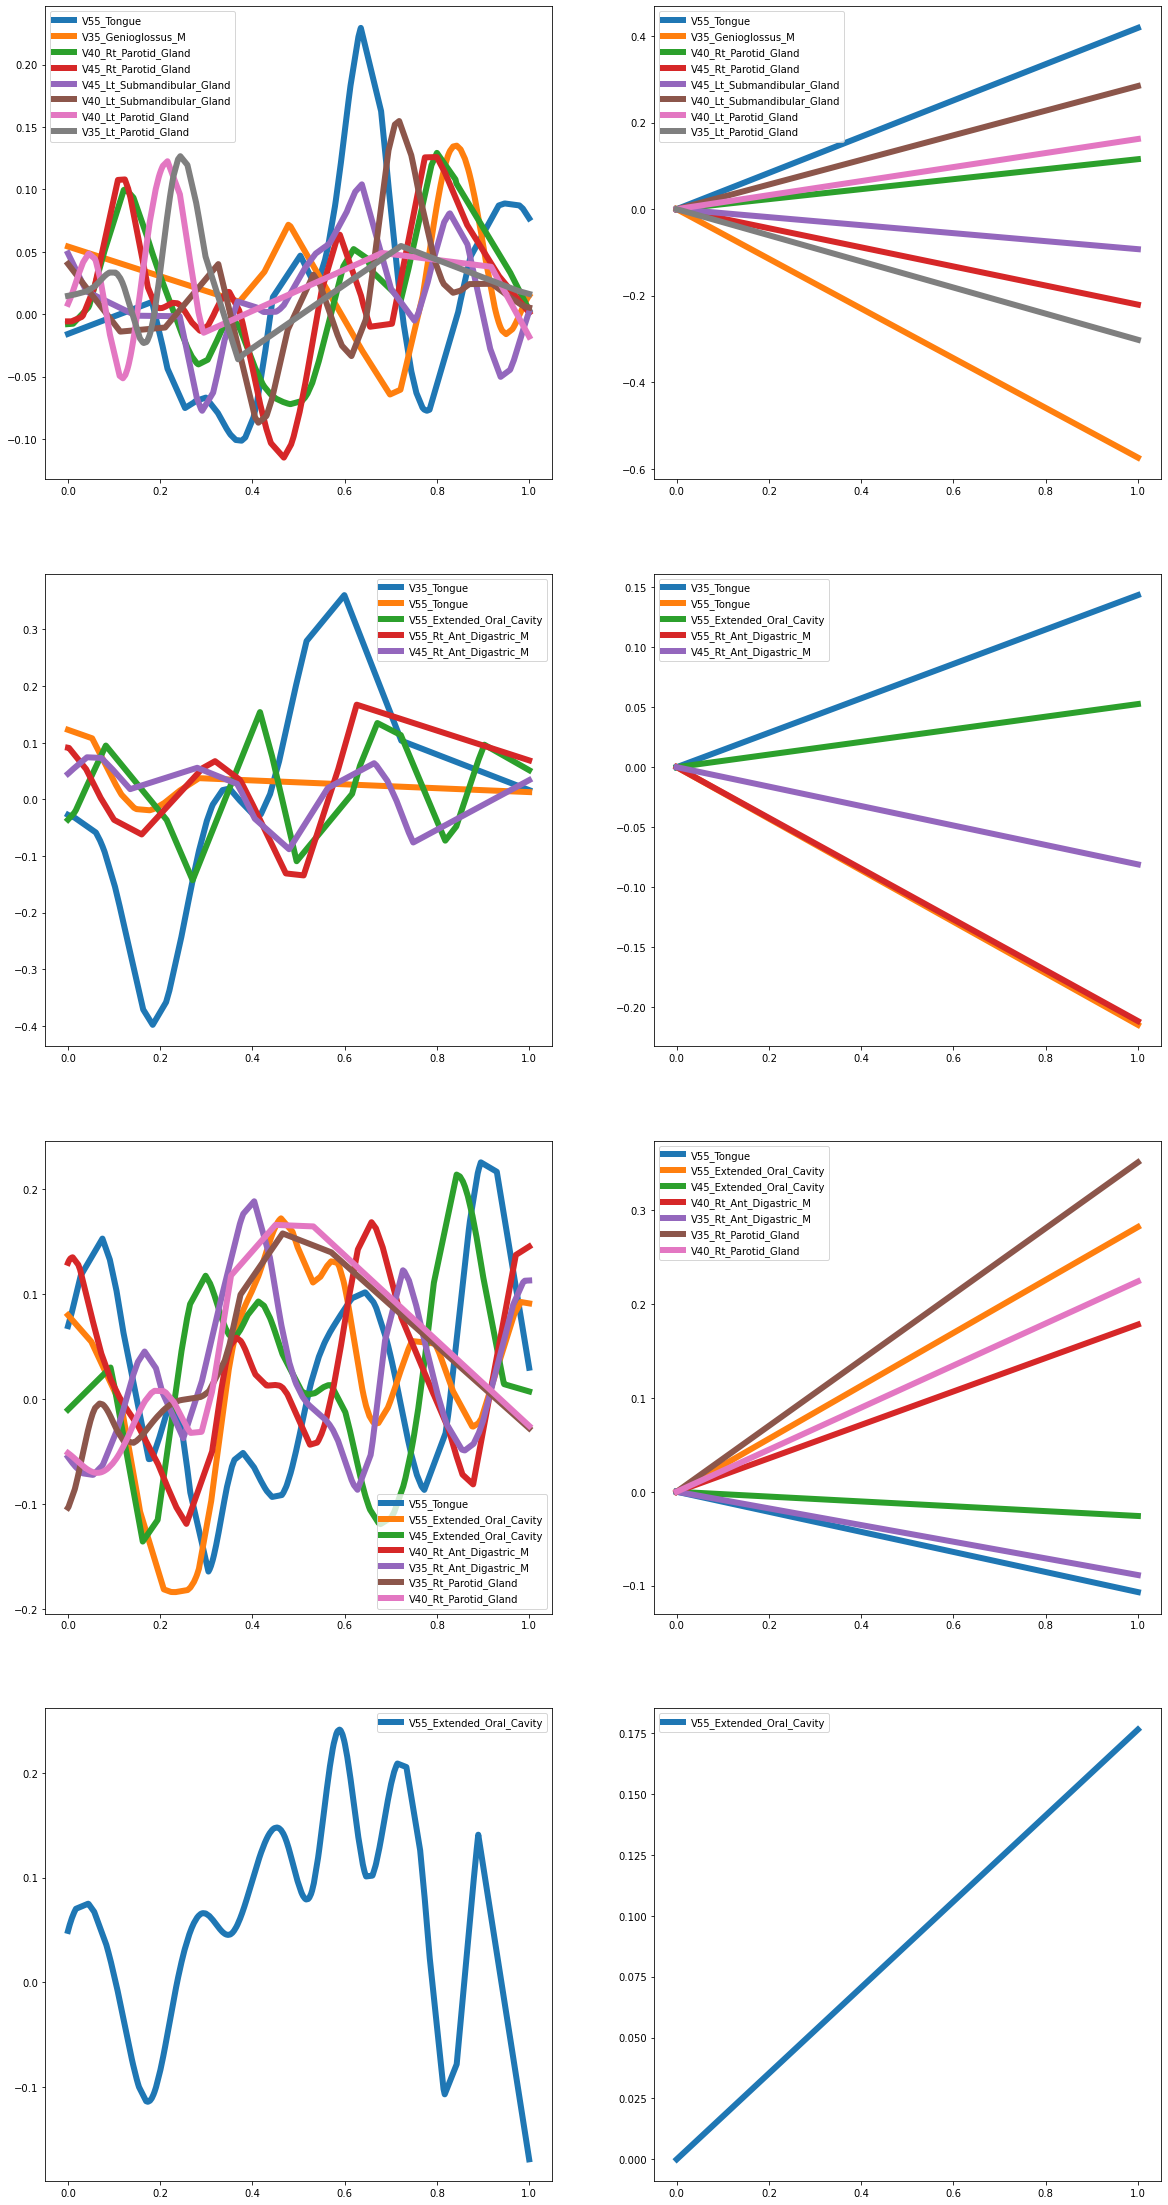

In [362]:
from pygam import LogisticGAM, LinearGAM
import pygam

def get_sample_cluster_metrics_input():
    with open(Const.data_dir+'cluster_post_test.json','r') as f:
        post_data= simplejson.load(f)
    return post_data

def add_gam_clusters(df,post_results):
    cmap = {}
    for c_entry in post_results['clusterData']:
        cId = c_entry['clusterId']
        for pid in c_entry['ids']:
            cmap[int(pid)] = cId
    df = df.copy()
    df['gam_cluster'] = df.id.apply(lambda i: cmap.get(int(i),-1))
    return df


def extract_dose_vals(df,organs,features):
    oidxs = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    df = df.copy()
    vals = []
    names = []
    for f in features:
        for (oname, oidx) in zip(organs,oidxs):
            values = df[f].apply(lambda x: x[oidx]).values
            vals.append(values.reshape((-1,1)))
            names.append(f+'_'+oname)
    vals = np.hstack(vals)
    vals = pd.DataFrame(vals,columns=names,index=df.index)
    return vals 

def extract_confounders(df,confounders):
    new_vals = {}
    for col in confounders:
        vals =df[col]
        unique_vals = vals.unique()
        if(len(unique_vals)) <= 2:
            new_vals[col] = (vals == vals.max()).values
        elif len(unique_vals) < 10:
            for uval in unique_vals:
                new_vals[col+'_'+str(uval)] = (vals == uval).values
        else:
            try:
                new_vals[col] = pd.to_numeric(vals,errors='coerce').fillna(0).values
            except Exception as e:
                print('error with column',)
    return pd.DataFrame(new_vals,index=df.index)


def get_outcomes(df,symptoms,dates,threshold=None):
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
    res = []
    get_max_sval = lambda s: df['symptoms_'+s].apply(lambda x: np.max([x[i] for i in date_idxs]) ).values
    res = {symp:get_max_sval(symp) for symp in symptoms}
    return pd.DataFrame(res,index=df.index)
    
    
def get_gam_inference_data(df,
                           confounders,
                           organs,
                           symptoms,
                           features, 
                           dates, 
                           cluster=None):
    if cluster is not None:
        df = df[df.gam_cluster.astype(int) == int(c)]
    df_doses = extract_dose_vals(df,organs,features)
    df_confounders = extract_confounders(df,confounders)
    outcome = get_outcomes(df,symptoms,dates)
    return [df_doses,outcome,df_confounders]
       
def is_series_binary(series):
    #looks at a numeric pd series and tells you if the terms are 0 + 1 or not
    if(isinstance(series, pd.Series)):
        return series.isin([0,1]).all()
    else:
        return np.isin(series,[0,1]).all()

def select_gam_features(doses,outcome,organs=None,k=2,min_val = .1):
    #uses mutual info to figure out what features to keep for gam stuff
    #k values max (or whatever # has any mutual info) for each organ.
    #organs = None will just pick top k over all features
    x = doses.apply(lambda x: (x-x.mean())/x.std())
    x = doses.apply(lambda x: (x-x.min())/(x.max()-x.min()))
    def group_sranks(sval):
        if sval < 3:
            return 0
        if sval < 5:
            return 1
        if sval < 7:
            return 2
        return 3
    if not is_series_binary(outcome):
        y = outcome.apply(lambda x: x.apply(group_sranks),axis=0)
        rankfunc =mutual_info_regression
    else:
        y = outcome
        rankfun = mutual_info_classif
    rankvals  = rankfunc(x.values,y.values.ravel())
    min_val = min(min_val,np.max(rankvals))
    ranks = [(c,v) for c,v in zip(doses.columns,list(rankvals))]
    
    ranks = sorted(ranks, key=lambda x: -x[1])
    #top values with max k above min val
    #min val < 0 should just return everything for mutual info
    topk = lambda vals: [v for v in vals[:min(len(vals),k)] if v[1] >= min_val]
    to_keep = []
    if organs is not None:
        for o in organs:
            options = [i for i in ranks if o in i[0]]
            if len(options) < 1:
                continue
            to_keep.extend(topk(options))
    else:
        to_keep = topk(ranks)
    best_doses = doses[[i[0] for i in to_keep]]
    return best_doses

def make_gam_model(dose_df,
                   outcome_df,
                   confounder_df,
                   organs=None,
                   threshold=5,
                   regularize=True,
                   gam_type='linear',
                   smoothing=.1,
                  ): 
    
    if threshold is not None:
        y = outcome_df >= threshold
    else:
        y = outcome_df/outcome_df.max()
        
    if(is_series_binary(y)):
        gamfunc = lambda terms: LogisticGAM(terms,max_iter=1000)
    else:
        gamfunc = lambda terms: LinearGAM(terms,max_iter=1000)
        
    if regularize:
        dose_df = dose_df.apply(lambda x: (x-x.mean() + .001)/(x.std() + .001),axis=0)
    x = dose_df.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis=0)
    
    def get_term(term_idx):
        if(is_series_binary(x.values[:,term_idx])):
            return f(term_idx)
        elif(gam_type == 'linear'):
            return pygam.l(term_idx, smoothing)
        else:
            return pygam.s(term_idx, lam=smoothing)
    
    terms = get_term(0)
    for extra_term in np.arange(1,x.shape[1]):
        terms += get_term(extra_term)
    
    m = gamfunc(terms).fit(x,y)
    return m, x
       
def make_gam_curve(gam, x,x_unnormalized=None):
    curves = []
    curve_names = []
    quants = [.05,.25,.75,.95]
    print(x.shape,x_unnormalized.shape)
    if x_unnormalized is None:
        x_unnormalized = x
    for i,col in enumerate(x.columns):
        xvals = x[col].values
        
        xvals = np.unique(xvals)
        pdep_input = np.zeros((len(xvals),len(x.columns)))
        pdep_input[:,i] = xvals
        ypred = gam.partial_dependence(i, pdep_input,
                                       meshgrid=False,
                                       quantiles = quants,
                                      )
        xtrue = x_unnormalized[col].values
        curves.append([xvals,ypred[0]])
        curve_names.append(col)
    return curves,curve_names

def get_stuff(df):
    post_results = get_sample_cluster_metrics_input()
    
    df = add_gam_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    confounders = post_results.get('lrtConfounders',['hpv','t3','t4','n_severe','Parotid_Gland_limit'])
    organs = post_results.get('organs',['IPC','MPC','SPC'])
    symptoms = post_results.get('symptoms',['drymouth'])
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    s_dates = post_results.get('symptom_dates',[13,33])
#     model_type= post_results.get('model_type','spline')
    threshold = post_results.get('threshold',None)
    
    models = []
    dose_df, outcome_df, confounder_df = get_gam_inference_data(df,
                                                              confounders,organs,
                                                              symptoms,
                                                              organ_features,
                                                              s_dates,
                                                             )
    for cluster in df.gam_cluster.unique() + [-1]:
        if cluster is not None and cluster > -1:
            cluster_index = df[df.gam_cluster == cluster].index
        else:
            cluster_index = df.index
        target = outcome_df[symptoms].loc[cluster_index]
        filtered_doses = select_gam_features(dose_df.loc[cluster_index],
                                             target,
                                             organs=organs,
                                            )
        for model_type in ['spline','linear']:
            gmodel, x = make_gam_model(
                filtered_doses,
                target,
                confounder_df.loc[cluster_index],
                threshold=threshold,
                gam_type=model_type,
            )
            pdep, pdep_names = make_gam_curve(gmodel,x,filtered_doses)
            entry = {
                'symptom': symptoms[0],
                'model':gmodel,
                'threshold': threshold,
                'cluster': cluster,
                'pdep': pdep,
                'pdep_names':pdep_names,
                'model_type':model_type,
            }
            models.append(entry)
    for entry in models:
        pass
    return models



temp = get_stuff(data)
def plot_gam_pdep(gtest_entry,ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    for [[x,y],name] in zip(gtest_entry['pdep'],gtest_entry['pdep_names']):
        line, = ax.plot(x,y,linewidth=6)
        line.set_label(name)
    return ax

def plot_gam_results(gamstuff):
    nitems = len(gamstuff)
    n_rows = nitems//2
    if n_rows < nitems/2:
        n_rows += 1
    fig,axes = plt.subplots(n_rows,2,figsize=(20,10*n_rows))
    col = 0
    row = 0
    for gitem in gamstuff:
        ax = axes[row,col]
        plot_gam_pdep(gitem,ax)
        col += 1
        if col > 1:
            row += 1
            col = 0
        ax.legend()
plot_gam_results(temp)

In [361]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def get_tree_stuff(df):
    post_results = get_sample_cluster_metrics_input()
    
    df = add_gam_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    confounders = post_results.get('lrtConfounders',['hpv','t3','t4','n_severe','Parotid_Gland_limit'])
    organs = post_results.get('organs',['IPC','MPC','SPC'])
    symptoms = post_results.get('symptoms',['drymouth'])
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    s_dates = post_results.get('symptom_dates',[13,33])
    threshold = post_results.get('threshold',5)
    cluster = post_results.get('cluster',None)
    
    dose_df, outcome_df, confounder_df = get_gam_inference_data(df,
                                                              confounders,organs,
                                                              symptoms,
                                                              organ_features,
                                                              s_dates,
                                                            cluster=cluster,
                                                             )
    y = (outcome_df>=threshold)
    print(dose_df.shape,y.shape)
    
    forest = RandomForestClassifier(n_estimators=1000,
                                    min_samples_leaf=int(dose_df.shape[0]/4),
                                    max_depth = 2)
    forest.fit(dose_df,y.values.ravel())
    rules = {}
    for estimator in forest.estimators_:
        t = estimator.tree_
        for (feature, thresh) in zip(t.feature,t.threshold):
            if feature < 0:
                continue
            fname = dose_df.columns[feature] 
            curr_ts = rules.get(fname,{})
            tcount = curr_ts.get(thresh,0)
            curr_ts[thresh] = tcount + 1
            rules[fname] = curr_ts
    rlist = []
    for feature, tentry in rules.items():
        for thresh, count in tentry.items():
            upper_split_idx = dose_df[(dose_df[feature] > thresh)].index
            lower_split_idx = dose_df[(dose_df[feature] <= thresh)].index
            rentry = {
                'feature': feature,
                'threshold': thresh,
                'rulecount': count,
                'upper_split_count': len(upper_split_idx),
                'lower_split_count': len(lower_split_idx),
                'upper_split_tp': y.loc[upper_split_idx].sum().values[0],
                'lower_split_tp': y.loc[lower_split_idx].sum().values[0],
                'upper_split_mean': y.loc[upper_split_idx].mean().values[0],
                'lower_split_mean': y.loc[lower_split_idx].mean().values[0],
            }
            rentry['odds_ratio'] = (rentry['upper_split_mean'] + .01)/(rentry['lower_split_mean'] + .01)
            rlist.append(rentry)
    rlist = sorted(rlist, key = lambda x: -x['odds_ratio'])
    return rlist
get_tree_stuff(data)

(349, 32) (349, 1)


[{'feature': 'V55_Tongue',
  'threshold': 35.984375,
  'rulecount': 16,
  'upper_split_count': 200,
  'lower_split_count': 149,
  'upper_split_tp': 126,
  'lower_split_tp': 64,
  'upper_split_mean': 0.63,
  'lower_split_mean': 0.42953020134228187,
  'odds_ratio': 1.4561001679645749},
 {'feature': 'V55_Tongue',
  'threshold': 35.03125,
  'rulecount': 6,
  'upper_split_count': 207,
  'lower_split_count': 142,
  'upper_split_tp': 129,
  'lower_split_tp': 61,
  'upper_split_mean': 0.6231884057971014,
  'lower_split_mean': 0.4295774647887324,
  'odds_ratio': 1.440447831194944},
 {'feature': 'V45_Genioglossus_M',
  'threshold': 70.625,
  'rulecount': 15,
  'upper_split_count': 201,
  'lower_split_count': 148,
  'upper_split_tp': 126,
  'lower_split_tp': 64,
  'upper_split_mean': 0.6268656716417911,
  'lower_split_mean': 0.43243243243243246,
  'odds_ratio': 1.4394642547798575},
 {'feature': 'V45_Genioglossus_M',
  'threshold': 70.53125,
  'rulecount': 1,
  'upper_split_count': 201,
  'lower_s

In [380]:
def get_rules(df,y,granularity=5,min_odds=1,k=2,min_split_size = 10):
    splits = []
    for col in df.columns:
        vals = df[col]
        minval = int(vals.min())
        currval = minval
        while currval < vals.max():
            upper_idx = y[(vals >= currval)].index
            lower_idx = y[(vals < currval)].index
            if min(len(upper_idx),len(lower_idx)) > min_split_size:
                upper_y = y.loc[upper_idx]
                lower_y = y.loc[lower_idx]
                sentry = {
                    'feature': col,
                    'threshold': currval,
                    'lower_count': lower_y.shape[0],
                    'upper_count': upper_y.shape[0],
                    'lower_mean': lower_y.mean().values[0],
                    'upper_mean': upper_y.mean().values[0],
                    'lower_positive': lower_y.sum().values[0],
                    'upper_positive': upper_y.sum().values[0],
                    'odds_ratio': ((upper_y.mean()+.01)/(lower_y.mean()+.01)).values[0],
                }
                if sentry['odds_ratio'] >= min_odds:
                    splits.append(sentry)
            currval += granularity
    rules = sorted(splits, key = lambda x: -x['odds_ratio'])
    if len(rules) > k:
        rules = rules[:k]
    return rules

def get_rule_stuff(df):
    post_results = get_sample_cluster_metrics_input()
    
    df = add_gam_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    confounders = post_results.get('lrtConfounders',['hpv','t3','t4','n_severe','Parotid_Gland_limit'])
    organs = post_results.get('organs',['IPC','MPC','SPC'])
    symptoms = post_results.get('symptoms',['drymouth'])
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    s_dates = post_results.get('symptom_dates',[13,33])
    threshold = post_results.get('threshold',5)
    cluster = post_results.get('cluster',None)
    
    dose_df, outcome_df, confounder_df = get_gam_inference_data(df,
                                                              confounders,organs,
                                                              symptoms,
                                                              organ_features,
                                                              s_dates,
                                                            cluster=cluster,
                                                             )
    y = (outcome_df>=threshold)
    rules = []
    for organ in organs:
        ocols = [c for c in dose_df.columns if organ in c]
        subdf = dose_df[ocols]
        o_rules = get_rules(subdf,y)
        rules.extend(o_rules)
    return sorted(rules,key=lambda x: -x['odds_ratio'])
    
get_rule_stuff(data)

[{'feature': 'V40_Rt_Parotid_Gland',
  'threshold': 75,
  'lower_count': 338,
  'upper_count': 11,
  'lower_mean': 0.5355029585798816,
  'upper_mean': 0.8181818181818182,
  'lower_positive': 181,
  'upper_positive': 9,
  'odds_ratio': 1.5181985819799033},
 {'feature': 'V45_Rt_Parotid_Gland',
  'threshold': 65,
  'lower_count': 338,
  'upper_count': 11,
  'lower_mean': 0.5355029585798816,
  'upper_mean': 0.8181818181818182,
  'lower_positive': 181,
  'upper_positive': 9,
  'odds_ratio': 1.5181985819799033},
 {'feature': 'V55_Tongue',
  'threshold': 35,
  'lower_count': 142,
  'upper_count': 207,
  'lower_mean': 0.4295774647887324,
  'upper_mean': 0.6231884057971014,
  'lower_positive': 61,
  'upper_positive': 129,
  'odds_ratio': 1.440447831194944},
 {'feature': 'V35_Lt_Submandibular_Gland',
  'threshold': 35,
  'lower_count': 60,
  'upper_count': 289,
  'lower_mean': 0.4,
  'upper_mean': 0.5743944636678201,
  'lower_positive': 24,
  'upper_positive': 166,
  'odds_ratio': 1.425352350409